In [69]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
accounts_df = pd.read_excel('accounts.xlsx')
clients_df = pd.read_excel('clients.xlsx')

In [5]:
# Create database and tables

conn = sqlite3.connect('debtcasestudydb.db')
c = conn.cursor()

c.execute("""CREATE TABLE account([clientid] TEXT, [account] INTEGER, [currentcreditor] TEXT, [originalcreditor] TEXT, 
        [beginningbalance] FLOAT, [settledflag] INTEGER, [settlementamount] FLOAT)""")

c.execute("""CREATE TABLE client([clientid] TEXT, [subscriptionproduct] INTEGER, [programstartdate] DATE, 
        [dateclosed] DATE, [status] TEXT, [clientstate] TEXT, [monthlyincome] FLOAT, [welcomecallcompletedate] DATE)
        """)

conn.commit()

accounts_df.to_sql('account', conn, if_exists='replace',index=False)
clients_df.to_sql('client', conn, if_exists='replace', index=False)

In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///debtcasestudydb.db')
conn = engine.connect()

In [33]:
#Determine difference in original debt vs settled debt for non subscribed clients

query = pd.read_sql("""
WITH CTE AS 
(SELECT a.ClientID, BeginningBalance-SettlementAmount AS Difference
FROM account a
INNER JOIN client c ON a.ClientID = c.ClientID
WHERE SubscriptionProduct = 0 AND SettledFlag = 1)

SELECT AVG(Difference) AS Debt_Difference FROM CTE
""", conn)
query

,Debt_Difference
0,2165.990894


In [18]:
#Determine difference in original debt vs settled debt for subscribed clients

query = pd.read_sql("""
WITH CTE AS 
(SELECT a.ClientID, BeginningBalance-SettlementAmount AS Difference
FROM account a
INNER JOIN client c ON a.ClientID = c.ClientID
WHERE SubscriptionProduct = 1 AND SettledFlag = 1)

SELECT AVG(Difference) AS Debt_Difference FROM CTE
""", conn)
query

,Debt_Difference
0,2005.018239


In [21]:
#Determine monthly duration of nonsubscribed clients 
#The julianday function is used in SQLite to determine the number of days between two dates
#Convert days to months by multiplying by .0328767

query = pd.read_sql("""
SELECT AVG(Monthly_Duration) AS Monthy_Duration
FROM
(SELECT ClientID, ROUND((julianday(DateClosed)-julianday(DATE(ProgramStartDate)))*.0328767,1) AS Monthly_Duration
FROM client
WHERE Status IN ('Terminated') AND SubscriptionProduct = 0)
""", conn)
query

,Monthy_Duration
0,3.361868


In [28]:
#Daily Duration

query = pd.read_sql("""
SELECT AVG(Daily_Duration) AS Daily_Duration
FROM 
(SELECT(julianday(DateClosed)-julianday(DATE(ProgramStartDate))) AS Daily_Duration
FROM client
WHERE Status in ('Terminated') AND SubscriptionProduct = 0)
""", conn)
query

,Daily_Duration
0,102.226585


In [54]:
#Determine monthly duration of subscribed clients 

query = pd.read_sql("""
SELECT AVG(Monthly_Duration) AS Monthly_Duration
FROM
(SELECT ClientID, ROUND((julianday(DateClosed)-julianday(DATE(ProgramStartDate)))*.0328767,1) AS Monthly_Duration
FROM client
WHERE Status IN ('Terminated') AND SubscriptionProduct = 1)
""", conn)
query

,Monthly_Duration
0,3.904135


In [68]:
#Monthly duration of subscribed vs. nonsubscribed high debt clients (>15000)

query = pd.read_sql("""
SELECT AVG(Monthly_Duration) AS Avg_Monthly_Duration_HNW
FROM
(SELECT c.ClientID, ROUND((julianday(DateClosed)-julianday(DATE(ProgramStartDate)))*.0328767,1) AS Monthly_Duration
FROM client c
INNER JOIN account a ON c.ClientID = a.ClientID
WHERE Status IN ('Terminated') AND SubscriptionProduct = 0 AND BeginningBalance > 15000.5)
""", conn)
query

,Avg_Monthly_Duration_HNW
0,3.085331


In [66]:
#Daily duration of subscribed vs. nonsubscribed high debt clients (>15000)

query = pd.read_sql("""
SELECT AVG(Daily_Duration) AS Avg_Daily_Duration_HNW
FROM
(SELECT c.ClientID, julianday(DateClosed)-julianday(DATE(ProgramStartDate)) AS Daily_Duration
FROM client c
INNER JOIN account a ON c.ClientID = a.ClientID
WHERE Status IN ('Terminated') AND SubscriptionProduct = 1 AND BeginningBalance > 15000.5)
""", conn)
query

,Avg_Daily_Duration_HNW
0,102.898017


In [6]:
#Number of settled accounts (subscribed vs non subscribed)

query = pd.read_sql("""
SELECT COUNT(a.account) AS Settled_Accounts, SettledFlag, SubscriptionProduct
FROM client c JOIN account a
ON c.ClientID = a.ClientID
WHERE SubscriptionProduct = 0 AND SettledFlag = 1
GROUP BY SettledFlag
""", conn)
query

,Settled_Accounts,SettledFlag,SubscriptionProduct
0,9410,1,0


In [65]:
#Determine number of clients in each original debt bin/bucket by subscription flag

query = pd.read_sql("""
SELECT COUNT(a.ClientID) as Clients, CASE 
    WHEN BeginningBalance BETWEEN 0.00 AND 500.00 THEN "0 to 500"
    WHEN BeginningBalance BETWEEN 500.01 AND 1000.00 THEN "500 to 1000"
    WHEN BeginningBalance BETWEEN 1000.01 AND 5000.00 THEN "1000 to 5000"
    WHEN BeginningBalance BETWEEN 5000.01 AND 10000.00 THEN "5000 to 10,000"
    WHEN BeginningBalance BETWEEN 10000.01 AND 15000.00 THEN "10,000 to 15,000"
    ELSE "Over 15,000"
    END AS 'DebtRange', SubscriptionProduct
FROM account a
INNER JOIN client c ON a.ClientID = c.ClientID
WHERE SubscriptionProduct = 0
GROUP BY DebtRange
UNION
SELECT COUNT(a.ClientID) Clients, CASE 
    WHEN BeginningBalance BETWEEN 0.01 AND 500.00 THEN "0 to 500"
    WHEN BeginningBalance BETWEEN 500.01 AND 1000.00 THEN "500 to 1000"
    WHEN BeginningBalance BETWEEN 1000.01 AND 5000.00 THEN "1000 to 5000"
    WHEN BeginningBalance BETWEEN 5000.01 AND 10000.00 THEN "5000 to 10,000"
    WHEN BeginningBalance BETWEEN 10000.01 AND 15000.00 THEN "10,000 to 15,000"
    ELSE "Over 15,000"
    END AS 'DebtRange', SubscriptionProduct
FROM account a
INNER JOIN client c ON a.ClientID = c.ClientID
WHERE SubscriptionProduct = 1
GROUP BY DebtRange
""", conn)
query.to_excel('debtranges.xlsx')

In [23]:
#Client Churn Model

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn import metrics 

df = pd.read_sql("""
SELECT c.ClientID, SubscriptionProduct, CASE
    WHEN WelcomeCallCompleteDate NOT IN ('1/0/1900') THEN '1'
    ELSE '0' END AS WelcomeCallStatus,
    CASE 
    WHEN Status = 'Client' THEN '0'
    WHEN Status = 'Completed' THEN '1'
    WHEN Status = 'Rescission' THEN '2'
    WHEN Status = 'Terminated' THEN '3'
    END AS ClientStatus, 
    MonthlyIncome, SUM(BeginningBalance) AS TotalBeginningDebt
FROM client c INNER JOIN account a ON c.ClientID = a.ClientID
WHERE ClientStatus NOT IN ('0')
GROUP BY c.ClientID
""", conn)

df.head()

,ClientID,SubscriptionProduct,WelcomeCallStatus,ClientStatus,MonthlyIncome,TotalBeginningDebt
0,ACT2550750,1,1,2,3515.0,6510.35
1,ACT2550900,0,1,3,3562.5,18662.75
2,ACT2553898,1,1,3,4539.1,8463.55
3,ACT2554159,1,1,3,2850.0,2275.25
4,ACT2555427,0,1,1,4767.1,32063.45


In [27]:
y = df['ClientStatus']
X = df[['SubscriptionProduct', 'WelcomeCallStatus', 'MonthlyIncome', 'TotalBeginningDebt']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
print("_______________")
print("Accuracy Score: ")
print(metrics.accuracy_score(y_test, y_pred))
print("_______________")
print("Classification Report: ")
print(classification_report(y_test, y_pred))

[[  0   4  49]
 [  0  20 188]
 [  2  43 548]]
_______________
Accuracy Score: 
0.6651053864168618
_______________
Classification Report: 
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        53
           2       0.30      0.10      0.15       208
           3       0.70      0.92      0.80       593

   micro avg       0.67      0.67      0.67       854
   macro avg       0.33      0.34      0.31       854
weighted avg       0.56      0.67      0.59       854



<class 'numpy.ndarray'>


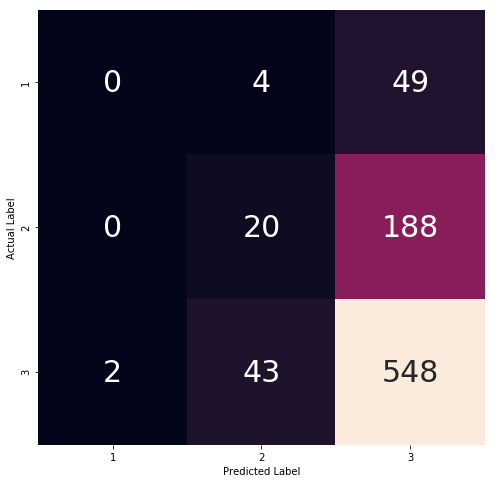

In [48]:
print(type(cm))
df_cm = pd.DataFrame(cm, index = [i for i in "123"],
                    columns = [i for i in '123'])

plt.figure(figsize = (8, 8))
sn.heatmap(df_cm, annot=True, cbar=False, annot_kws={'size': 30}, fmt='.0f')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()